In [1]:
from nilearn import plotting, image, datasets
from nilearn.maskers import NiftiMapsMasker
import nibabel as nib

(66, 78, 66)


/home/leah/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



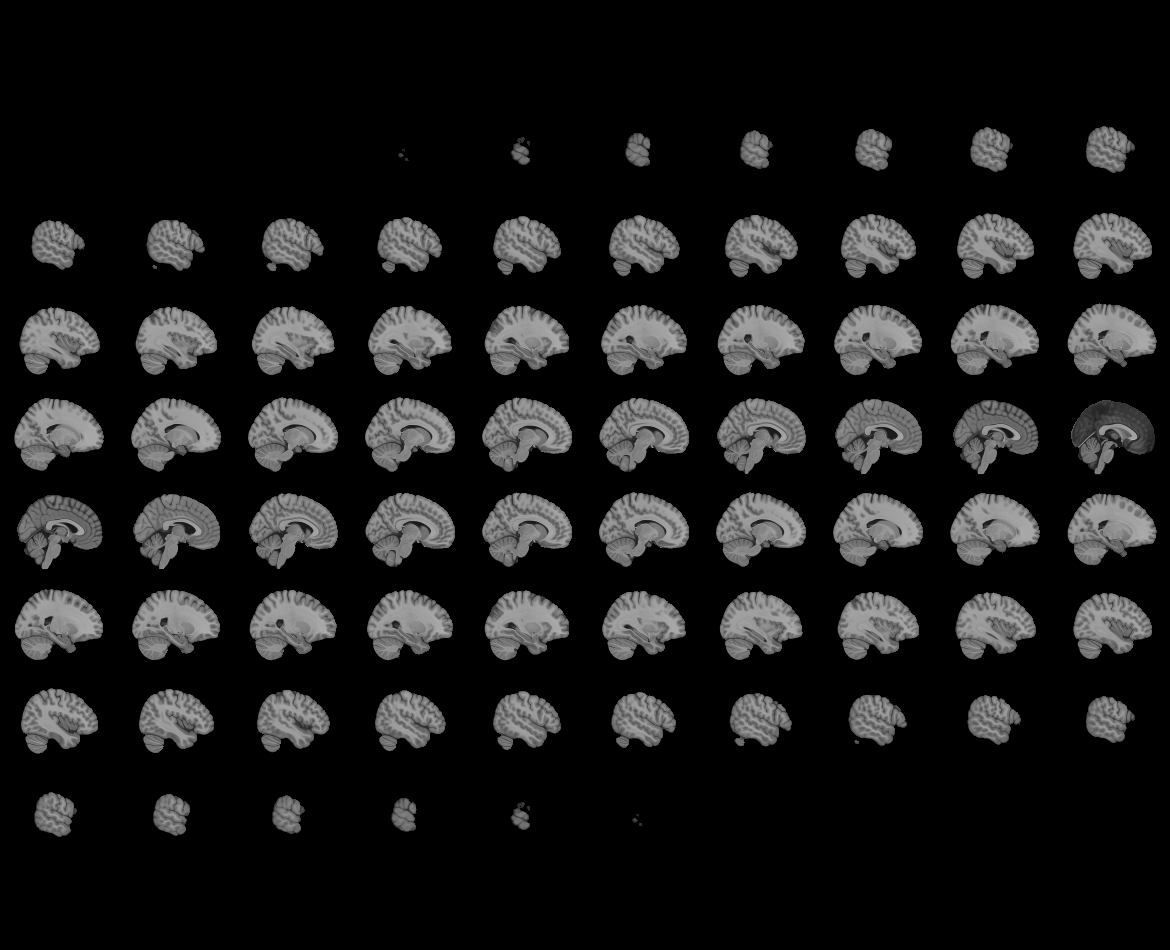
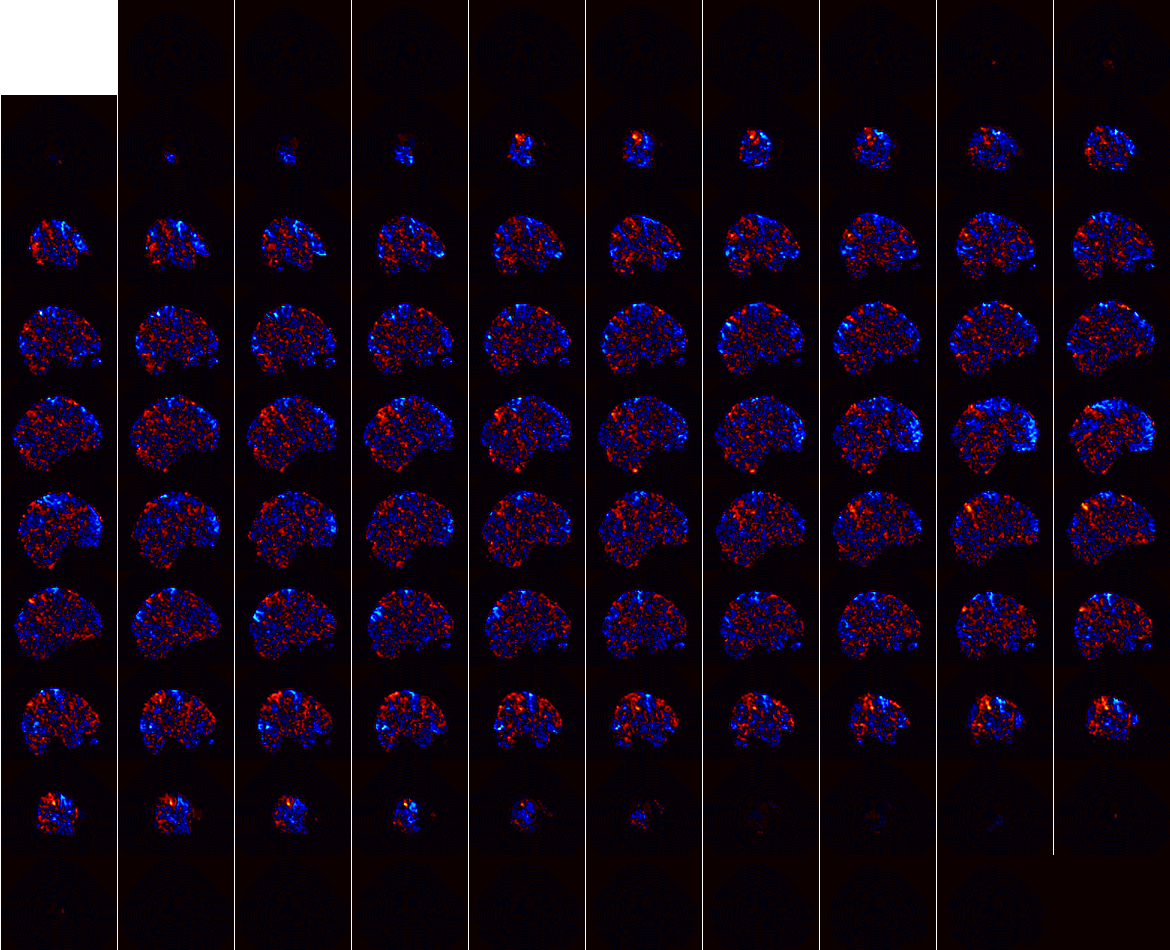

In [5]:
# load Heart-Brain map from SPM first level output (using instandtaneous hrv as regressor)
subject = "0020" # example subject
data_path = "/mnt/raid0/scratch/BIDS/derivatives/heart-brain_coupling/"
HFhrv_path = f"{data_path}/{subject}/spmT_0001.nii" # high frequency hrv 
LFhrv_path = f"{data_path}/{subject}/spmT_0002.nii" # low frequency hrv

# plot High Freq HRV - Brain image
HFhrv_img = nib.load(HFhrv_path)
print(HFhrv_img.shape)
plotting.view_img(HFhrv_img, threshold=None)

(66, 78, 66)


/home/leah/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



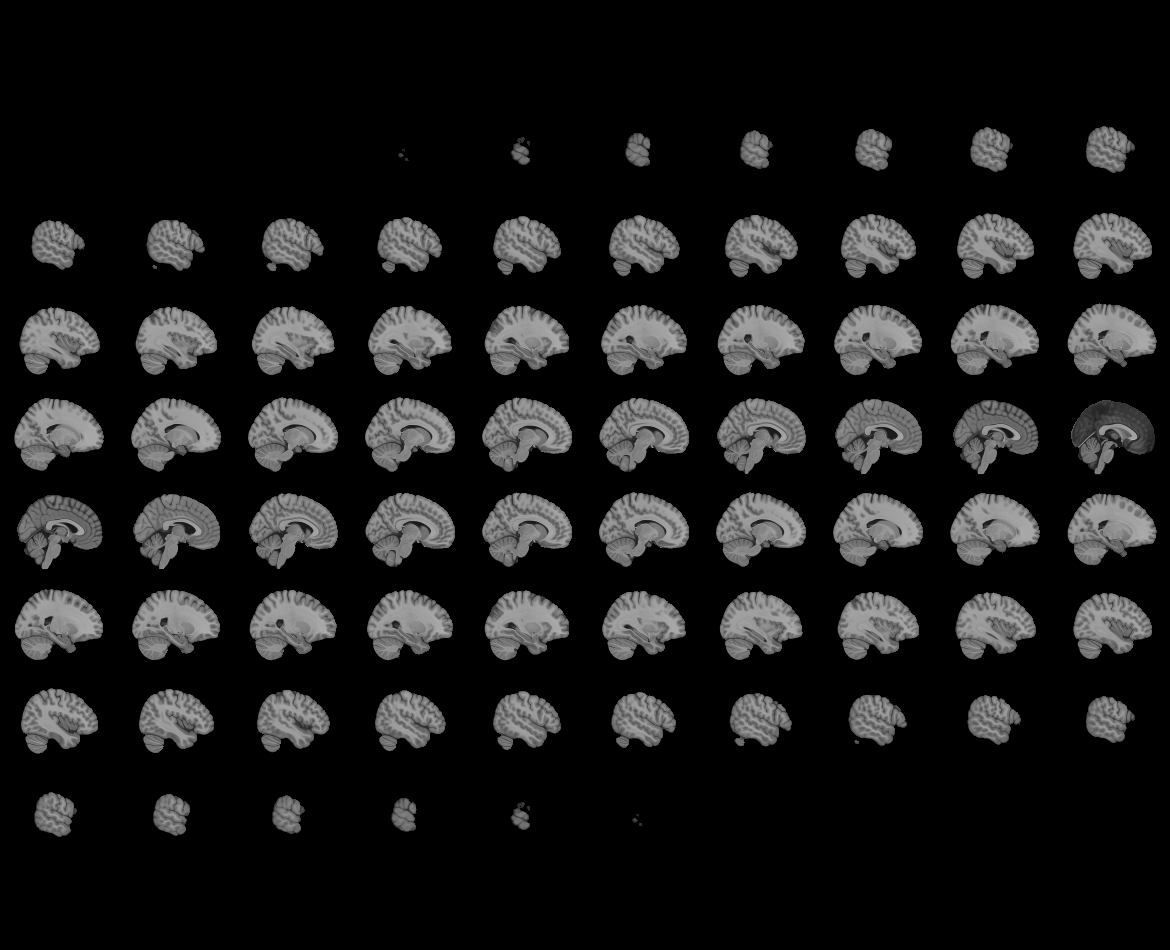
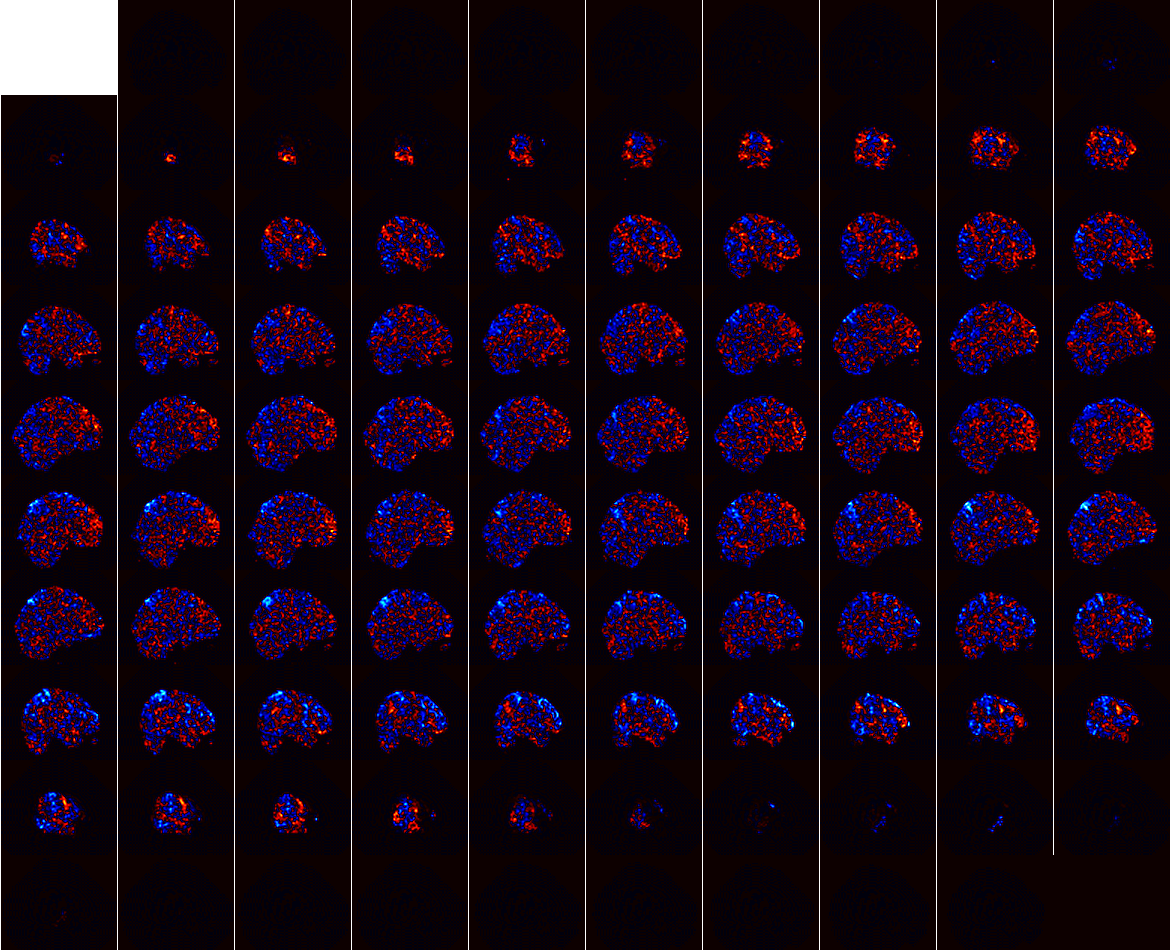

In [7]:
# plot Low Freq HRV - Brain image
LFhrv_img = nib.load(LFhrv_path)
print(LFhrv_img.shape)
plotting.view_img(LFhrv_img, threshold=None)

In [8]:
# load Dictionaries of Functional Modes (“DiFuMo”) atlas (for parcellation)
dim = 256
difumo = datasets.fetch_atlas_difumo(dimension=dim, resolution_mm=3)
#labels = difumo.labels

# Load the DiFuMo atlas from the file path
difumo_maps_img = nib.load(difumo.maps)
#print(difumo_maps_img.shape)

# Create a masker object for difumo - with 3mm brain mask (NiftiMapsMasker is useful when data from overlapping volumes - Summarizes brain signals from large-scale networks - Note that, Inf or NaN present in the given input images are automatically put to zero rather than considered as missing data)
masker = NiftiMapsMasker(maps_img=difumo.maps) #, mask_img=mask_img
 
# Extract the parcellated regions (apply masker object to image) - High Freq
HFhrv_parcels = masker.fit_transform(HFhrv_img)
HFhrv_parcels.shape

# Extract the parcellated regions (apply masker object to image) - Low Freq
LFhrv_parcels = masker.fit_transform(LFhrv_img)
LFhrv_parcels.shape


/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/atlas.py:131: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


(1, 256)

In [9]:
# run above - looping for all subjects - create csv of difumo-parcellated HeartBrain values (each row = each subject)
import pandas as pd
from nilearn import plotting, image, datasets
from nilearn.maskers import NiftiMapsMasker
import nibabel as nib
import os

# load subList of subjects with HeartBrain data
data_path = "/mnt/raid0/scratch/BIDS/derivatives/heart-brain_coupling/"
subjects = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
    
# remove subjects rejected from mriqc:
subs2rej = ["0019", "0034", "0039", "0132", "0138", "0180", "0229", "0397", "0419", "0437", "0587", "0351", "0388", "0454", "0485", "0173", "0207", "0036", "0223", "0187", "0237", "0273", "0287"] 
subjects = [subject for subject in subjects if subject not in subs2rej]

#subjects = subjects[0:2]

dim = 256
all_subjects_cols = ['subject'] + [f'parcel_{i+1}' for i in range(dim)]
all_subjects_HFhrv = pd.DataFrame(columns=all_subjects_cols)
all_subjects_LFhrv = pd.DataFrame(columns=all_subjects_cols)

# load Dictionaries of Functional Modes (“DiFuMo”) atlas
difumo = datasets.fetch_atlas_difumo(dimension=dim, resolution_mm=3)
# Create a masker object for difumo - with mask
masker = NiftiMapsMasker(maps_img=difumo.maps) #, mask_img=mask_img

for subject in subjects:

    if subject == "":
        continue
    
    # load HeartBrain data 
    HFhrv_path = f"{data_path}/{subject}/spmT_0001.nii" # high frequency hrv 
    LFhrv_path = f"{data_path}/{subject}/spmT_0002.nii" # low frequency hrv

    HFhrv_img = nib.load(HFhrv_path)
    LFhrv_img = nib.load(LFhrv_path)

    # parcellate heartbrain t-values with difumo256
    HFhrv_parcels = masker.fit_transform(HFhrv_img)
    LFhrv_parcels = masker.fit_transform(LFhrv_img)
    
    # Append the subject and HeartBrain parcels to the DataFrame
    subject_data_HFhrv = [subject] + list(HFhrv_parcels[0])
    all_subjects_HFhrv = all_subjects_HFhrv.append(pd.Series(subject_data_HFhrv, index=all_subjects_cols), ignore_index=True)
    
    subject_data_LFhrv = [subject] + list(LFhrv_parcels[0])
    all_subjects_LFhrv = all_subjects_LFhrv.append(pd.Series(subject_data_LFhrv, index=all_subjects_cols), ignore_index=True)

save_path = '/home/leah/Git/StomachBrain-MentalHealth/data/control_neuro_data/'  
all_subjects_HFhrv .to_csv(save_path + f'HFhrv_difumo{dim}_mriqc.csv', index=False)
all_subjects_LFhrv .to_csv(save_path + f'LFhrv_difumo{dim}_mriqc.csv', index=False)


/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/atlas.py:131: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
/tmp/ipykernel_2353524/1644112833.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_subjects_HFhrv = all_subjects_HFhrv.append(pd.Series(subject_data_HFhrv, index=all_subjects_cols), ignore_index=True)
/tmp/ipykernel_2353524/1644112833.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_subjects_LFhrv = all_subjects_LFhrv.append(pd.Series(subject_data_LFhrv, index=all_subjects_cols), ignore_index=True)
/tmp/ipykernel_2353524/1644112833.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v